In [3]:
import os
import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd


In [7]:
# The outputs of the linear regression, which are our input
output_dir_base = r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\EEG data\outputs"
# Info identifying the arch, checkpoint, version of code and whatever
#run_dir = "2024-02-16_15-54-47 - v2 resnet18 ch200"
run_dir = "2024-02-15_13-17-59 - v2 resnet50 ch1100"

# Add text to graph titles, if needed
additional_title_info = ""

#selected_layers = ["layer4", "fc2"] 
selected_layers = ["layer2", "layer3", "layer4", "fc2"]

# Merge them
output_dir = os.path.join(output_dir_base, run_dir)

n_timepoints = 512
downsampling_factor = 4

# List of selected subjects
selected_subjects = range(5,36)


# List
selected_channels = ['Iz', 'Oz', 'POz', 'P3', 'P4']

original_sampling_rate = 1024

# EEG channels by name (const)
channel_order = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'left', 'right', 'above', 'below']

# A subset of channels that are visual system related
################################ Define util funcs

# Get indexes of the selected channels
selected_channel_indexes = [channel_order.index(channel) for channel in selected_channels]

In [8]:

def read_data(output_dir):
    
    all_info = {}
    
    # Initialize lists to hold flattened data
    subject_list = []
    layer_list = []
    channel_list = []
    stat_list = []
    timepoint_list = []
    value_list = []
    
    # Loop over all data and load everything
    for sub in selected_subjects:
        # Make dir
        subject_dir = os.path.join(output_dir, f"sub_{sub}")
    
        subject_info = {}
        
        for layer_name in selected_layers:
            # Get dir
            layer_dir = os.path.join(subject_dir, layer_name)
    
            # Dicts for all channels
    
            layer_info = {}
            
            for channel in selected_channels:
                #channel_name = channel_order[channel]
                # Get dir
                channel_dir = os.path.join(layer_dir, channel)
    
                # Load data
                train_rs = np.load(os.path.join(channel_dir, "train_rs.npy"))
                train_r2s = np.load(os.path.join(channel_dir, "train_r2s.npy"))
                train_betas = np.load(os.path.join(channel_dir, "train_betas.npy"))
                #train_lin_regs = np.load(os.path.join(channel_dir, "train_lin_regs.npy"))
                test_rs = np.load(os.path.join(channel_dir, "test_rs.npy"))
                test_r2s = np.load(os.path.join(channel_dir, "test_r2s.npy"))
    
                channel_data = {
                'train_rs': train_rs,
                'train_r2s': train_r2s,
                #'train_betas': train_betas,
                #'train_lin_regs': train_lin_regs,
                'test_rs': test_rs,
                'test_r2s': test_r2s,
                #'test_betas': test_betas
                }
                
                layer_info[channel] = channel_data
    
                # save the data length
                downsampled_num_points = len(test_rs)
    
    
                # Also make a "flat" list for pandas
                for stat, timepoints_array in channel_data.items():
                    # Append the corresponding subject, layer, channel, stat for each timepoint
                    for idx, timepoint in enumerate(timepoints_array):
                        subject_list.append(sub)
                        layer_list.append(layer_name)
                        channel_list.append(channel)
                        stat_list.append(stat)
                        timepoint_list.append(idx)
                        value_list.append(timepoint)
    
            #plot_layer(layer_info, layer_name, sub)
            
            subject_info[layer_name] = layer_info
        #plot_subject(subject_info)
        
        all_info[sub] = subject_info
    #plot_whatever(all_info)
    
    # save the data length
    n_timepoint = len(test_rs)
    
    
    # Create a pandas df
    data_flat = pd.DataFrame({
        'Subject': subject_list,
        'Layer': layer_list,
        'Channel': channel_list,
        'Stat': stat_list,
        'Timepoint': timepoint_list,
        'Value': value_list
    })

    return data_flat #, all_info



In [7]:

data_flat = read_data(output_dir)

# Separate to avoid confusion / bugs

train_rs_df = data_flat[data_flat['Stat'] == 'train_rs']
train_r2s_df = data_flat[data_flat['Stat'] == 'train_r2s']
test_rs_df = data_flat[data_flat['Stat'] == 'test_rs']
test_r2s_df = data_flat[data_flat['Stat'] == 'test_r2s']

In [ ]:
# Plot with a corresponding time axis
import seaborn


# Mapping -100 to 400 ms to the range of timepoints
custom_xlim = (-100, 400)
timepoint_range = (test_rs_df['Timepoint'].min(), test_rs_df['Timepoint'].max())

# Calculate the mapping factor
time_mapping_factor = (timepoint_range[1] - timepoint_range[0]) / (custom_xlim[1] - custom_xlim[0])

# Map timepoints to the custom time range using .loc
test_rs_df.loc[:, 'Time_mapped'] = (test_rs_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]
test_r2s_df.loc[:, 'Time_mapped'] = (test_r2s_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]


# Create the line plot
my_plot = seaborn.relplot(data=test_rs_df, x="Time_mapped", y="Value", hue="Channel", col="Layer", kind="line", col_wrap=2)

# Correlation
#my_plot.set_titles([f"{run_dir} test $R^2$ MEAN Layer {i}" for i in range(len(test_rs_df['Layer'].unique()))])
my_plot.set_titles('{col_name}')
my_plot.fig.suptitle(f"{run_dir} TEST Correlations MEAN", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean Pearson's r", clear_inner=False)


# R^2
my_plot = seaborn.relplot(data=test_r2s_df, x="Time_mapped", y="Value", hue="Channel", col="Layer", kind="line", col_wrap=2)

my_plot.set_titles('{col_name}')
my_plot.fig.suptitle(f"{run_dir} TEST $R^2$ MEAN", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean $R^2$", clear_inner=False)

In [ ]:
# Load multiple models

#run_dir = "2024-02-16_15-54-47 - v2 resnet18 ch200"
def get_test_data(run_dir):
    output_dir = os.path.join(output_dir_base, run_dir)
    data_flat = read_data(output_dir)

    # Add the model in a new column
    data_flat['Model']=run_dir
    
    #train_rs_df = data_flat[data_flat['Stat'] == 'train_rs']
    #train_r2s_df = data_flat[data_flat['Stat'] == 'train_r2s']
    test_rs_df = data_flat[data_flat['Stat'] == 'test_rs']
    test_r2s_df = data_flat[data_flat['Stat'] == 'test_r2s']

    return test_rs_df, test_r2s_df

# Start reading data
test_rs_df1, test_r2s_df1 = get_test_data("2024-02-16_15-54-47 - v2 resnet18 ch200")
test_rs_df2, test_r2s_df2 = get_test_data("2024-02-21_16-00-34 CIFAR10 ch100")
test_rs_df3, test_r2s_df3 = get_test_data("2024-02-21_14-31-09 RANDOM TESTING DATA") # TODO: change to alexnet when its ready


In [11]:
# Put everything in one df
test_rs_df = pd.concat([test_rs_df1, test_rs_df2, test_rs_df3])
test_r2s_df = pd.concat([test_r2s_df1, test_r2s_df2, test_r2s_df3])

# Add proper time in ms
# Mapping -100 to 400 ms to the range of timepoints
custom_xlim = (-100, 400)
timepoint_range = (test_rs_df['Timepoint'].min(), test_rs_df['Timepoint'].max())

# Calculate the mapping factor
time_mapping_factor = (timepoint_range[1] - timepoint_range[0]) / (custom_xlim[1] - custom_xlim[0])

# Map timepoints to the custom time range using .loc
test_rs_df.loc[:, 'Time_mapped'] = (test_rs_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]
test_r2s_df.loc[:, 'Time_mapped'] = (test_r2s_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]


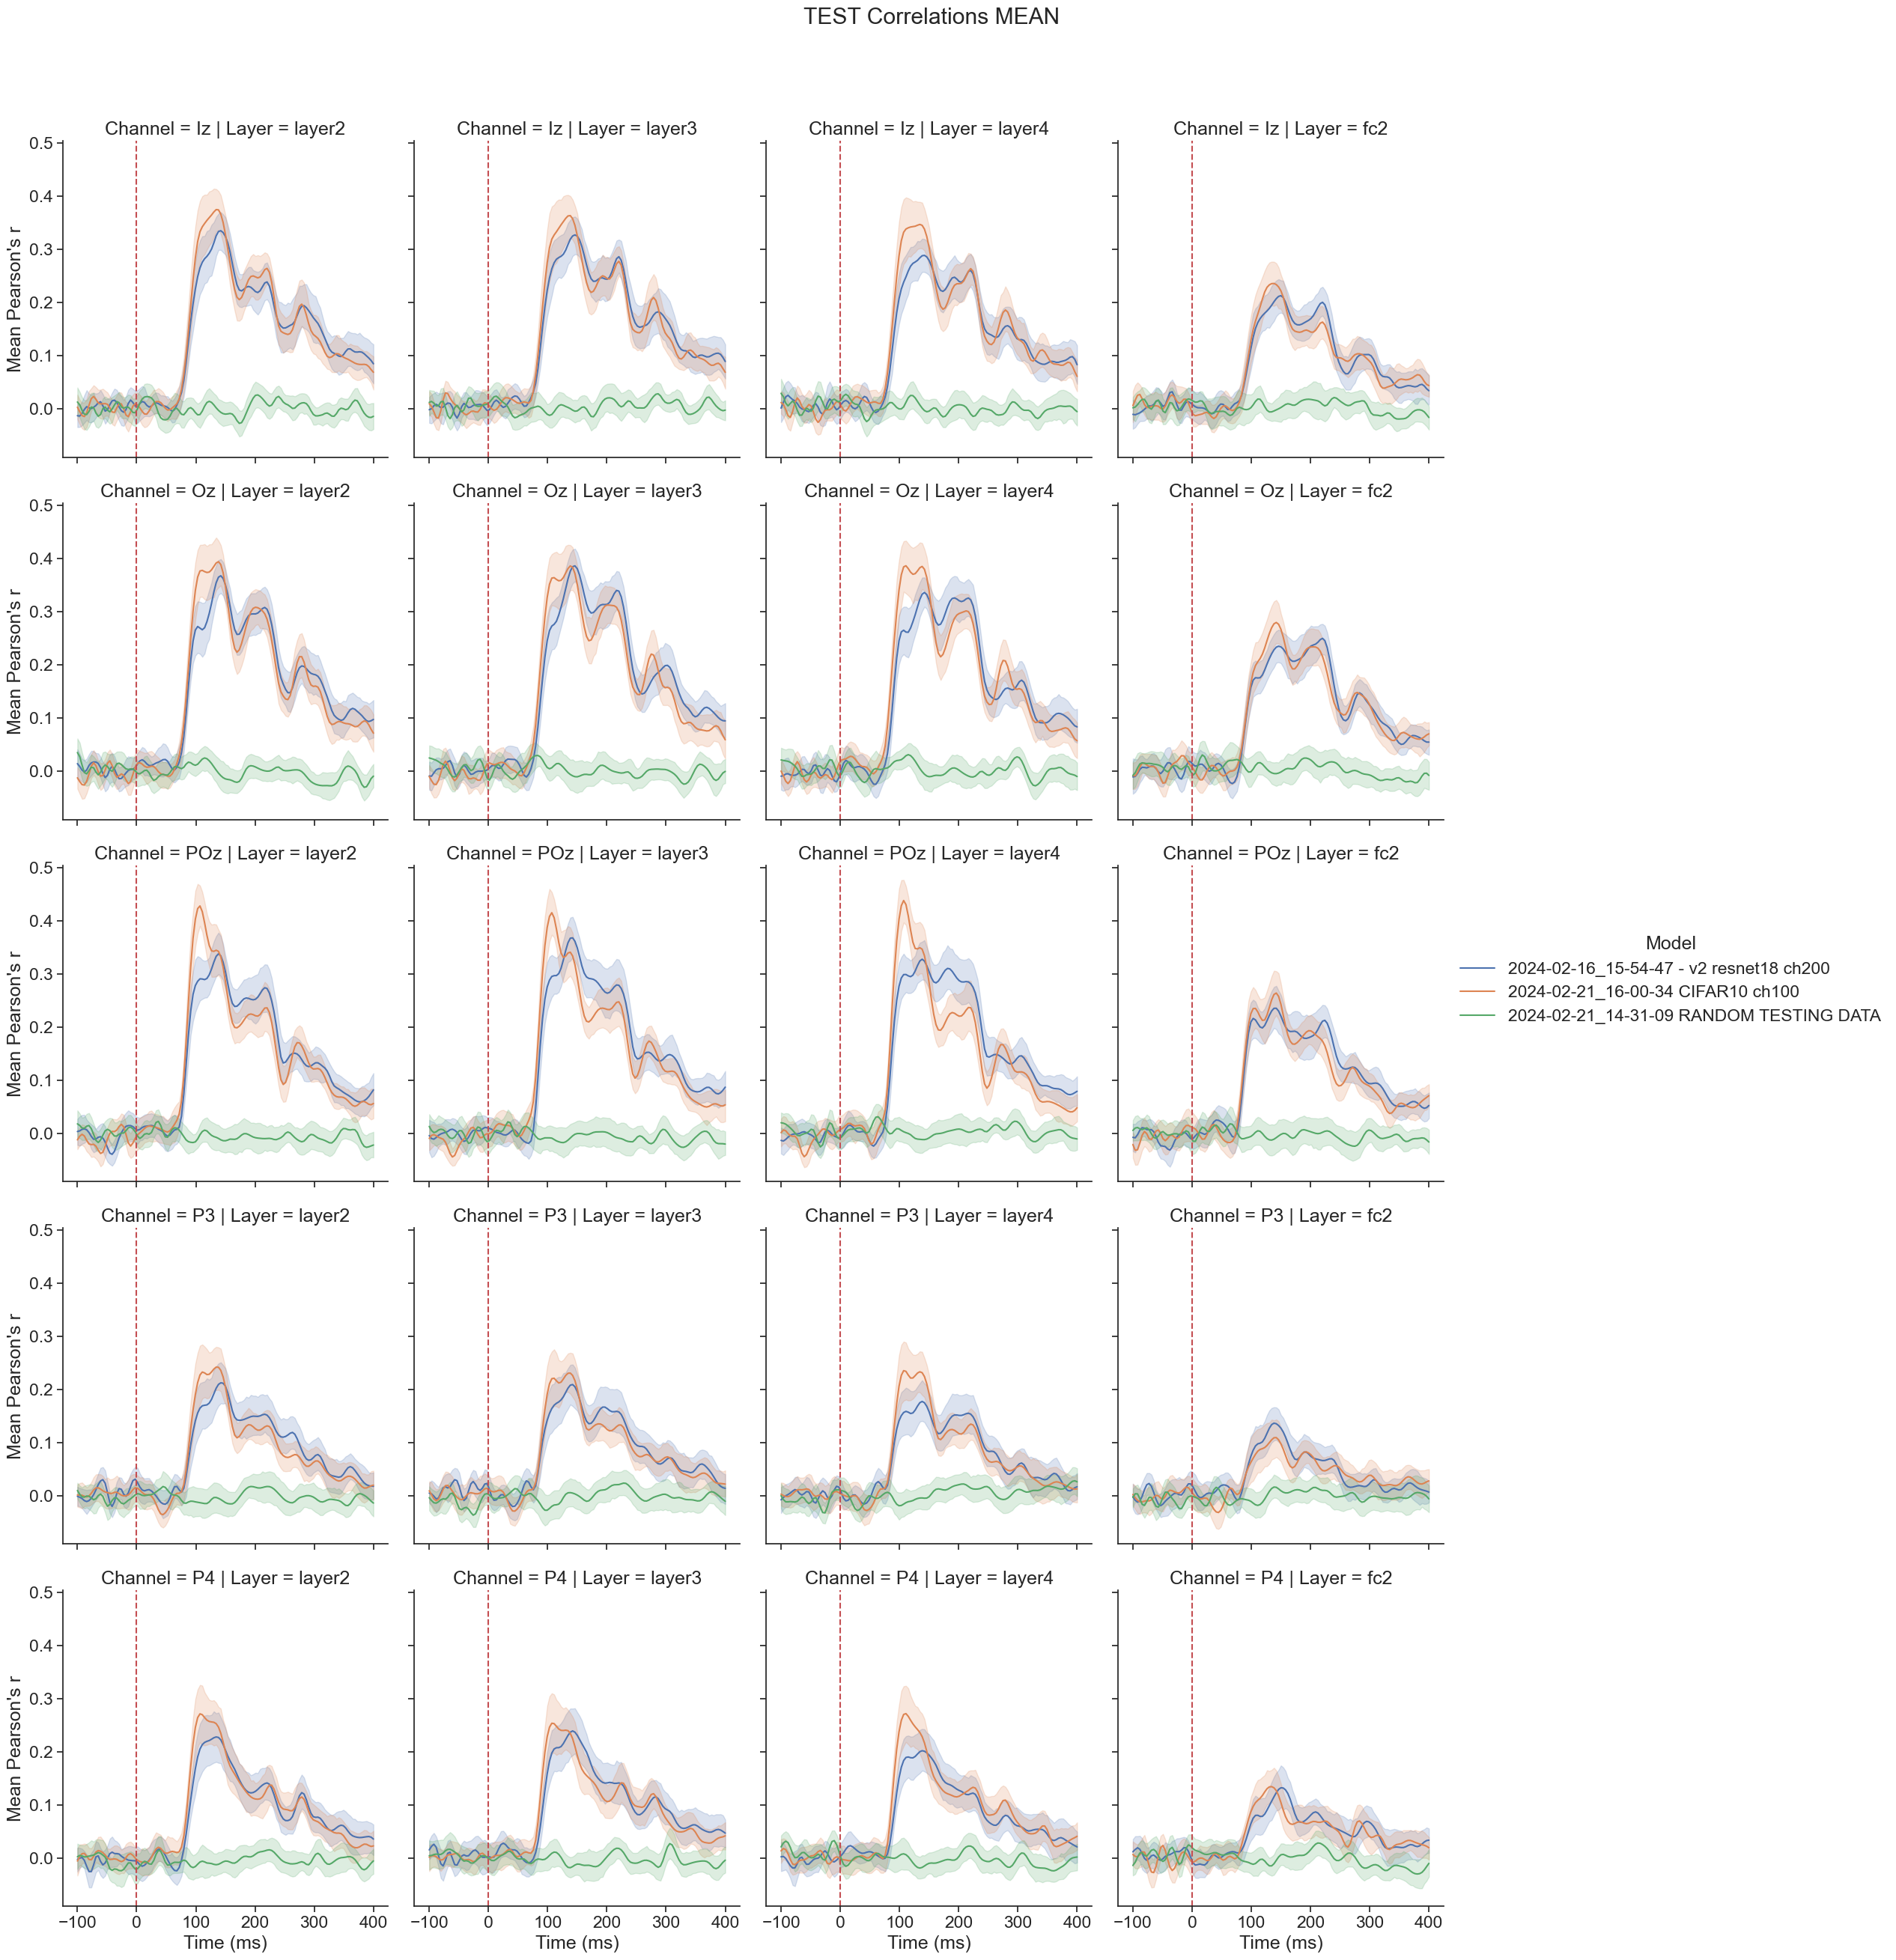

In [23]:
# Plot models against each other
import seaborn

seaborn.set(font_scale=1.5)
seaborn.set_style('ticks')

# Choose some specific layer or channel or whatever
data = test_rs_df#[test_rs_df['Channel'] == 'Oz']


# Correlation
my_plot = seaborn.relplot(data=data, x="Time_mapped", y="Value", hue="Model", col="Layer", row="Channel", kind="line")


# Add xline at x=0 for each plot
for ax in my_plot.axes.flat:
    # Add a vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--')

#my_plot.set_titles('{row_name} {col_name}')
my_plot.fig.suptitle(f"TEST Correlations", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean Pearson's r", clear_inner=False)



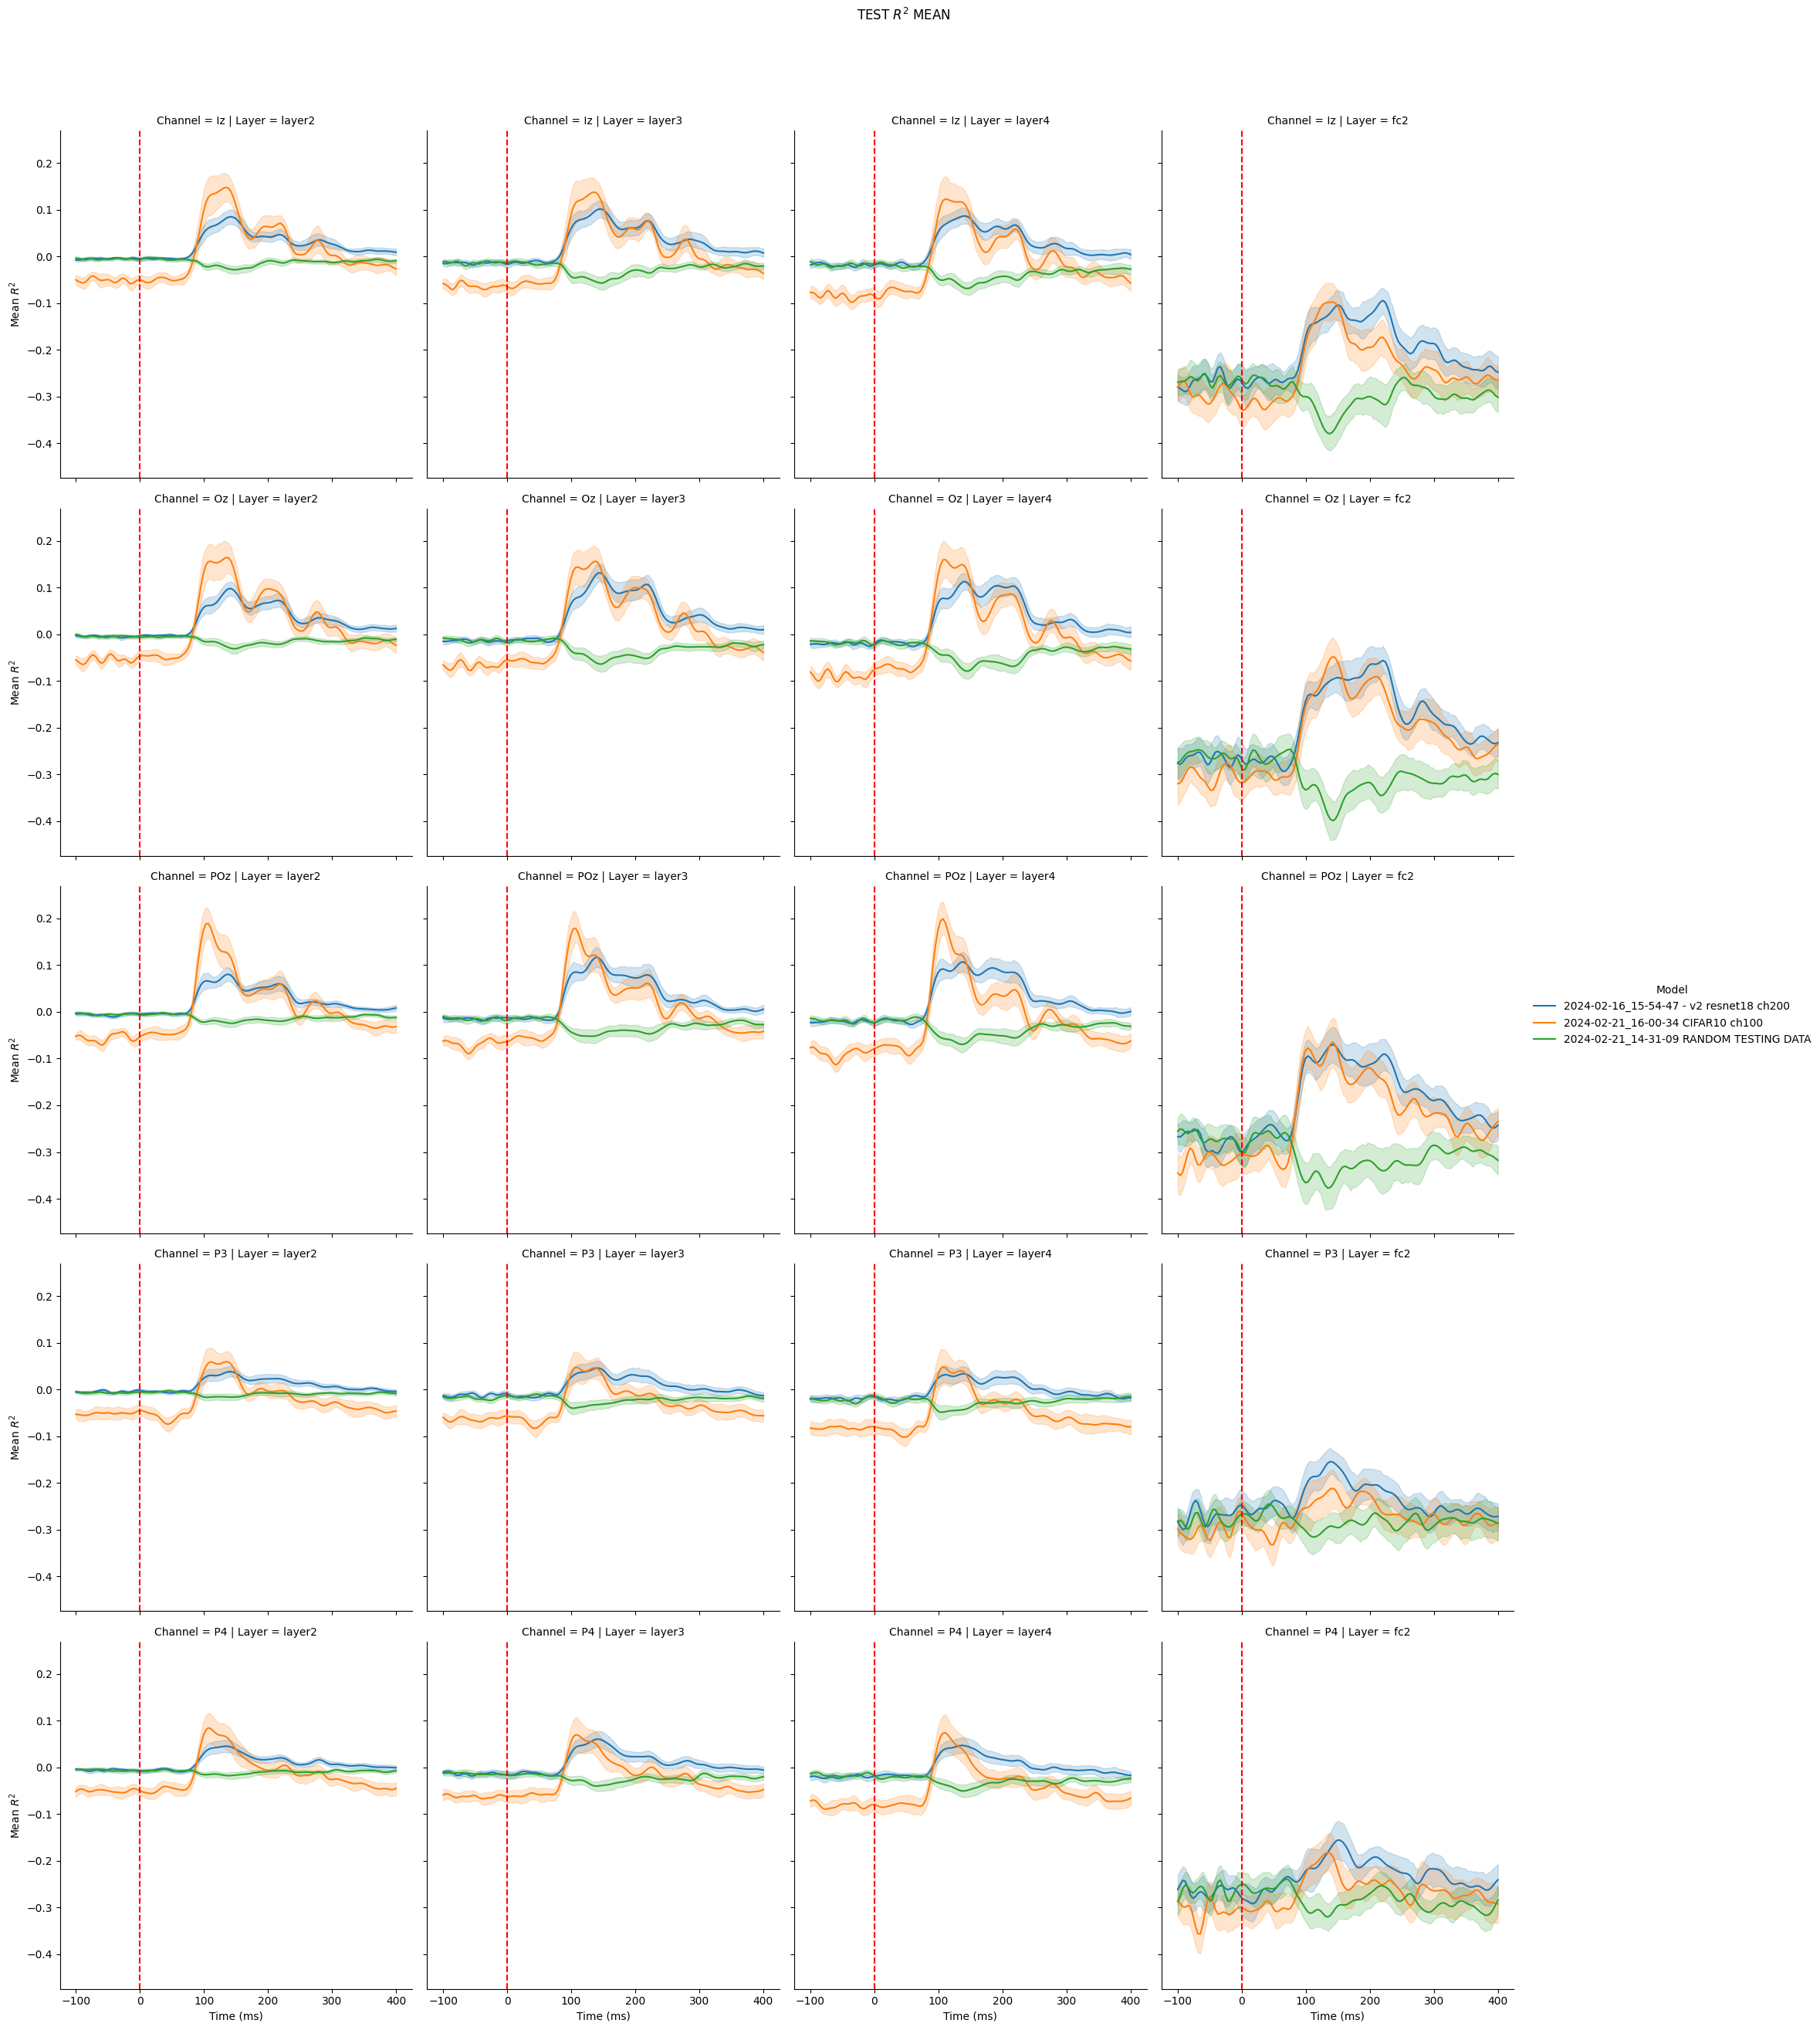

In [22]:

# TODO: same for R^2

# Choose some specific layer or channel or whatever
data_r2 = test_r2s_df#[test_r2s_df['Channel'] == 'Oz']


my_plot = seaborn.relplot(data=data_r2, x="Time_mapped", y="Value", hue="Model", col="Layer", row="Channel", kind="line")

# Add xline at x=0 for each plot
for ax in my_plot.axes.flat:
    # Add a vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--')

#my_plot.set_titles('{row_name} {col_name}')
my_plot.fig.suptitle(f"TEST $R^2$", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean $R^2$", clear_inner=False)

In [ ]:
### Old plotting

In [ ]:
def plot_rs(data, labell="", ylabel="", title="", downsampling_factor=downsampling_factor):
    """Plot either an r2 or an r graph with a -100 to 400ms timeline"""

    # Length of the downsampled data
    downsampled_num_points = len(data)

    # Calculate original number of points
    original_num_points = downsampled_num_points * downsampling_factor

    # Calculate the corresponding time range
    time_range_seconds = original_num_points / original_sampling_rate  # Duration of original data in seconds
    time_range_ms = time_range_seconds * 1000  # Convert duration to milliseconds
    time_start_ms = -100  # Start time in milliseconds
    time_end_ms = time_start_ms + time_range_ms  # End time in milliseconds

    # Create time axis
    time_axis = np.linspace(time_start_ms, time_end_ms, downsampled_num_points)

    # Plot the graph
    plt.plot(time_axis, data, label=labell)
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axvline(x=0, color='r', linestyle='--')  # Add a dashed vertical line at time = 0ms
    plt.grid(True)
    #plt.show()

In [6]:
def plot_channel(channel_data):
    """Do stuff with multiple channels on one layer and one subject"""
    pass


def plot_layer(layer_info, layer_name, sub):
    """Do stuff with multiple channels on one layer and one subject"""

    # Plot R2 
    plot_title = f"{run_dir} {additional_title_info} subject {sub} {layer_name}  TEST $R^2$"
    # Plot multiple lines in one thingy
    for channel, data in layer_info.items():
        plot_rs(data["test_r2s"], labell=channel, ylabel=f'$R^2$', title=plot_title)
    plt.legend(loc='best')
    plt.show()
    
    # Plot correlations
    plot_title = f"{run_dir} {additional_title_info} subject {sub} {layer_name} TEST CORRELATIONS"
    # Plot multiple lines in one thingy
    for channel, data in layer_info.items():
        plot_rs(data["test_rs"], labell=channel, ylabel=f'Pearson‛s  r', title=plot_title)
    plt.legend(loc='best')
    plt.show()
    

def plot_subject(subject_info):
    """Do stuff on multiple layers and channels on one subject"""
    pass


def plot_whatever(all_info):
    """Get all the data and do whatever u want"""
    pass

In [119]:
# Average across subjects for each channel

n_timepoint = len(test_rs)

def get_average_per_channel(df):

     # Initialize an empty dictionary to store the average values for each channel at each timepoint
    average_values_dict = {channel: np.zeros(n_timepoint) for channel in selected_channels}
    
    # Nested loops to iterate over each channel and each timepoint
    for channel in selected_channels:
        for timepoint in range(n_timepoint):
            # Use boolean indexing to select data based on both timepoint and channel
            channel_timepoint_data = df[(df['Timepoint'] == timepoint) & (df['Channel'] == channel)]
            
            # Calculate the average value for the current channel and timepoint
            average_value = channel_timepoint_data['Value'].mean()
            
            # Store the average value in the dictionary
            average_values_dict[channel][timepoint] = average_value

    return average_values_dict


# test corrs
#train_rs_averages = get_average_per_channel(train_rs_df)
#train_r2s_averages = get_average_per_channel(train_r2s_df)
#test_rs_averages = get_average_per_channel(test_rs_df)
#test_r2s_averages = get_average_per_channel(test_r2s_df)


test_rs_layer4_averages = get_average_per_channel(test_rs_df[test_rs_df["Layer"] == "layer4"])


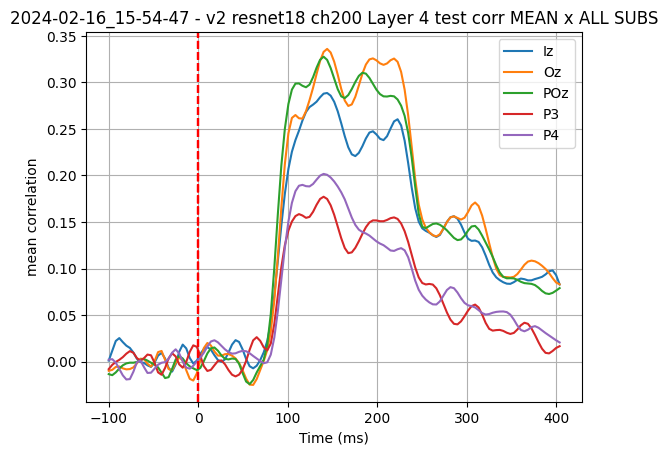

In [107]:
def plot_all_channels(layer_data, ylabel="", title=""):
    """Do stuff with multiple channels on one layer and one subject"""

    # Plot multiple lines in one thingy
    for channel, data in layer_data.items():
        plot_rs(data, labell=channel, ylabel=ylabel, title=title)
    plt.legend(loc='best')
    plt.show()


plot_all_channels(test_rs_layer4_averages, ylabel="mean correlation", title=f"{run_dir} Layer 4 test corr MEAN x ALL SUBS")

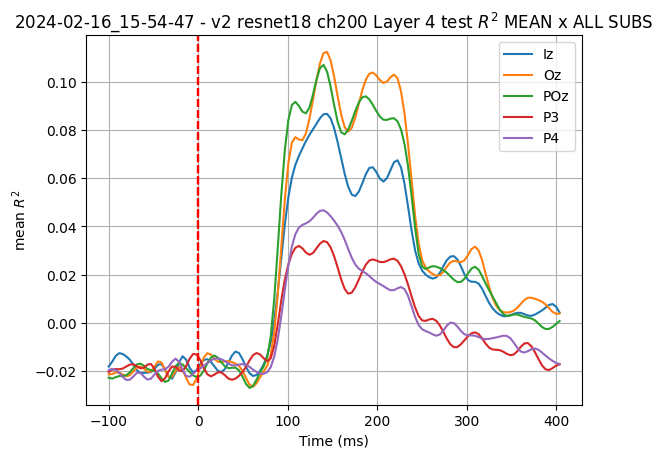

In [108]:
test_r2s_layer4_averages = get_average_per_channel(test_r2s_df[test_r2s_df["Layer"] == "layer4"])
plot_all_channels(test_r2s_layer4_averages, ylabel="mean $R^2$", title=f"{run_dir} Layer 4 test $R^2$ MEAN x ALL SUBS")